In [1]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Define image dimensions
img_height, img_width = 128, 128

# Data Preprocessing and Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Apply rescaling to validation and testing data as well
validation_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    'C:/Users/GOUTHAM REDDY/OneDrive/Desktop/BTP/baseline/train',
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    'C:/Users/GOUTHAM REDDY/OneDrive/Desktop/BTP/baseline/validation',
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='binary'
)
validation_generator.shuffle = False

test_generator = test_datagen.flow_from_directory(
    'C:/Users/GOUTHAM REDDY/OneDrive/Desktop/BTP/baseline/test',
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='binary'
)


Found 4320 images belonging to 2 classes.
Found 2880 images belonging to 2 classes.
Found 7200 images belonging to 2 classes.


In [3]:

# Define the number of classes
num_classes = 2  # Change this to match the number of classes in your dataset (binary, in this case)

# Load the pre-trained EfficientNetB0 model (excluding the top classification layer)
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Allow some layers in the base model to be trainable
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Add a global average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Add dropout for regularization

# Add a fully connected layer with softmax activation for classification
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Use the Adam optimizer with default learning rate (adjust if needed)
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define a learning rate scheduler
def lr_scheduler(epoch):
  return 0.0001

# Create a LearningRateScheduler callback
lr_callback = LearningRateScheduler(lr_scheduler)

In [4]:
from PIL import Image
import PIL
from keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='loss',  # Metric to monitor for improvement (training loss in this case)
    patience=5,      # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore model weights to the best epoch
)

# Train the model with EarlyStopping
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    callbacks=[lr_callback, early_stopping]
)


Epoch 1/10
135/135 [==============================] - 308s 2s/step - loss: 0.1346 - accuracy: 0.9495 - lr: 1.0000e-04
Epoch 2/10
135/135 [==============================] - 281s 2s/step - loss: 0.0237 - accuracy: 0.9933 - lr: 1.0000e-04
Epoch 3/10
135/135 [==============================] - 288s 2s/step - loss: 0.0140 - accuracy: 0.9958 - lr: 1.0000e-04
Epoch 4/10
135/135 [==============================] - 286s 2s/step - loss: 0.0118 - accuracy: 0.9970 - lr: 1.0000e-04
Epoch 5/10
135/135 [==============================] - 289s 2s/step - loss: 0.0044 - accuracy: 0.9993 - lr: 1.0000e-04
Epoch 6/10
135/135 [==============================] - 308s 2s/step - loss: 0.0046 - accuracy: 0.9986 - lr: 1.0000e-04
Epoch 7/10
135/135 [==============================] - 290s 2s/step - loss: 0.0034 - accuracy: 0.9991 - lr: 1.0000e-04
Epoch 8/10
135/135 [==============================] - 294s 2s/step - loss: 0.0063 - accuracy: 0.9984 - lr: 1.0000e-04
Epoch 9/10
135/135 [==============================] - 29

In [5]:
# Calculate the length of the test generator
test_steps = len(test_generator)

# Set shuffle=False for the test generator
test_generator.shuffle = False

# Evaluate the model using the test generator with the batch size equal to the test generator length
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_steps)

print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}")


225/225 [==============================] - 114s 496ms/step - loss: 3.8504 - accuracy: 0.4996
Test loss: 3.8504, Test accuracy: 0.4996


In [ ]:
pip install scikit-learn

225/225 [==============================] - 134s 595ms/step
True Positives: 0
False Positives: 3
True Negatives: 3597
False Negatives: 3600
Accuracy: 0.4996
APCER: 0.0008
BPCER: 1.0000


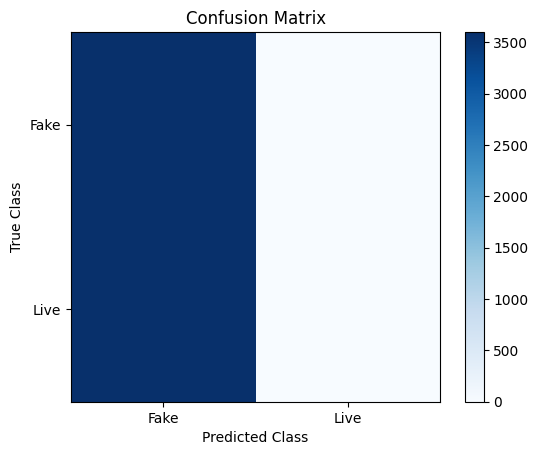

              precision    recall  f1-score   support

        Fake       0.50      1.00      0.67      3600
        Live       0.00      0.00      0.00      3600

    accuracy                           0.50      7200
   macro avg       0.25      0.50      0.33      7200
weighted avg       0.25      0.50      0.33      7200



In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Predict classes for test data
y_pred = model.predict(test_generator)

threshold = 0.5

# Convert probabilities to binary class predictions using threshold
y_pred_classes = (y_pred[:,1]>= threshold).astype(int)

y_true = test_generator.classes

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Extract TP, FP, TN, FN
TP = conf_matrix[1, 1]
FP = conf_matrix[0, 1]
TN = conf_matrix[0, 0]
FN = conf_matrix[1, 0]

# Calculate metrics
accuracy = (TP + TN) / (TP + TN + FP + FN)
apcer = FP / (FP + TN)
bpcer = FN / (FN + TP)

# Print metrics
print(f"True Positives: {TP}")
print(f"False Positives: {FP}")
print(f"True Negatives: {TN}")
print(f"False Negatives: {FN}")
print(f"Accuracy: {accuracy:.4f}")
print(f"APCER: {apcer:.4f}")
print(f"BPCER: {bpcer:.4f}")

# Display confusion matrix
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.xticks([0, 1], ['Fake', 'Live'])
plt.yticks([0, 1], ['Fake', 'Live'])
plt.show()

# Classification report
print(classification_report(y_true, y_pred_classes, target_names=['Fake', 'Live']))

In [9]:
import pandas as pd
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_pred_class_0 = y_pred[:, 0]
y_pred_class_1 = y_pred[:, 1]
y_true = test_generator.classes

# Create a DataFrame
data = pd.DataFrame({'y_true': y_true, 'y_pred_class_0': y_pred_class_0, 'y_pred_class_1': y_pred_class_1})

# Specify the full path to your desired directory in Google Drive
google_drive_path = 'C:/Users/GOUTHAM REDDY/OneDrive/Desktop/BTP/baseline/'

# Specify the CSV filename
csv_filename = 'efficientnet_predictions.csv'

# Save the DataFrame to a CSV file in the Google Drive directory
data.to_csv(google_drive_path + csv_filename, index=False)

print(f"CSV file saved to: {google_drive_path + csv_filename}")


225/225 [==============================] - 118s 520ms/step
CSV file saved to: C:/Users/GOUTHAM REDDY/OneDrive/Desktop/BTP/baselineefficientnet_predictions.csv


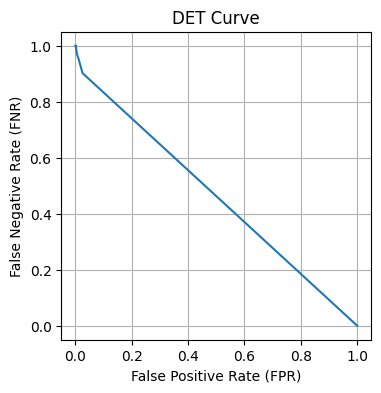

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate True Positive Rate (TPR) and False Positive Rate (FPR) for different thresholds
thresholds = np.arange(0, 1.01, 0.01)  # You can adjust the range and step size
fpr_list = []
fnr_list = []

for threshold in thresholds:
    y_pred_classes = (y_pred[:, 1] >= threshold).astype(int)
    tp = np.sum((y_true == 1) & (y_pred_classes == 1))
    fp = np.sum((y_true == 0) & (y_pred_classes == 1))
    fn = np.sum((y_true == 1) & (y_pred_classes == 0))
    tn = np.sum((y_true == 0) & (y_pred_classes == 0))

    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)

    fpr_list.append(fpr)
    fnr_list.append(fnr)

# Plot DET curve
plt.figure(figsize=(4, 4))
plt.plot(fpr_list, fnr_list)
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('False Negative Rate (FNR)')
plt.title('DET Curve')
plt.grid(True)
plt.show()

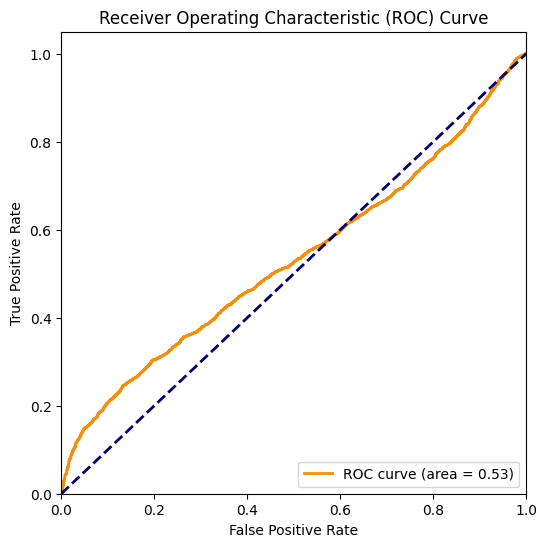

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming you have y_pred and y_true already defined
y_scores = y_pred[:, 1]  # Probabilities of belonging to class 1

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_scores)

# Compute AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
